In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import libpysal
import spopt
import esda
import networkx as nx
import pygeoda

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

import os

from src import config, utils, plotting, algorithms, evaluation

In [2]:
features = pd.read_parquet(config.FEATURES_11)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

# 1 Preparing dataset for clustering

## 1.1 Temporarily remove small islands from the dataset

NYC has a few islands of 1-3 tracts that have people in them but aren't contiguous with the rest of the data. This will break some of the spatial clustering algorithms, so let's cut them from the main dataset and just consider each one its own cluster.

In [3]:
# -- Cut out islands --
min_cluster_size = 5
tracts, small_islands = utils.remove_small_islands(
    tracts, n_min=min_cluster_size
)
features_small_islands = [features.loc[island.index].copy() \
                          for island in small_islands]
features = features.loc[tracts.index]

We've identified four population "islands" that are not contiguous by land to any well-populated Census tracts. From left to right: City Island (The Bronx), Roosevelt Island (Manhattan), Breezy Point (Queens), and Broad Channel (Queens).

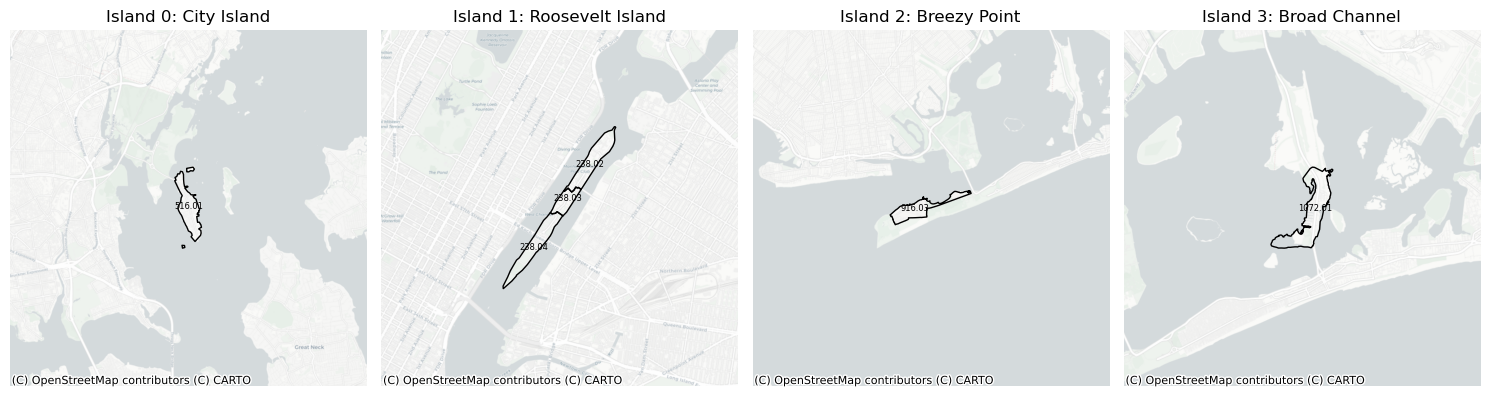

In [4]:
island_names = ["City Island", "Roosevelt Island", "Breezy Point", "Broad Channel"]

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i, island in enumerate(small_islands):
    __, __ = plotting.plot_tracts(island, figax=(fig, ax[i]))
    ax[i].set_title(f"Island {i}: {island_names[i]}")

The remaining 2206 Census tracts are split into five contiguous chunks: The Bronx, Manhattan, Queens/Brooklyn, Staten Island, and Rockaway Beach.

## 1.2 Standardize features

I want all of my features to be given equal weight in clustering, so I will standardize my features by z-score (rescaling and shifting to have a mean of 0 and standard deviation of 1).

In [5]:
# -- Standardize features --
feature_cols = features.columns
features_std = features.copy()
features_std[feature_cols] = StandardScaler().fit_transform(
    features_std[feature_cols]
)

# 2 Clustering algorithms

## 2.1 $k$-means clustering (`kmeans`)

To start, I want to cluster our dataset using $k$-means as a baseline. The benefits of this method are its speed, conceptual simplicity, and widespread use, making it a good initial attempt.

For this attempt, I will give the algorithm 10 clusters to work with. Ultimately, I will want many more, but this will provide a good diagnostic of how well the model performs.

In [19]:
# Define name of clustering model
alg = algorithms.kmeans
NC = 10
NF = len(features.columns)
model_name = f"f{NF}_{alg.code}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Solve
labels = alg(nyc_demographics, attrs, n=NC, seed=42)
labels.name = model_name

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Text(0.5, 1.0, 'kmeans, 10 clusters')

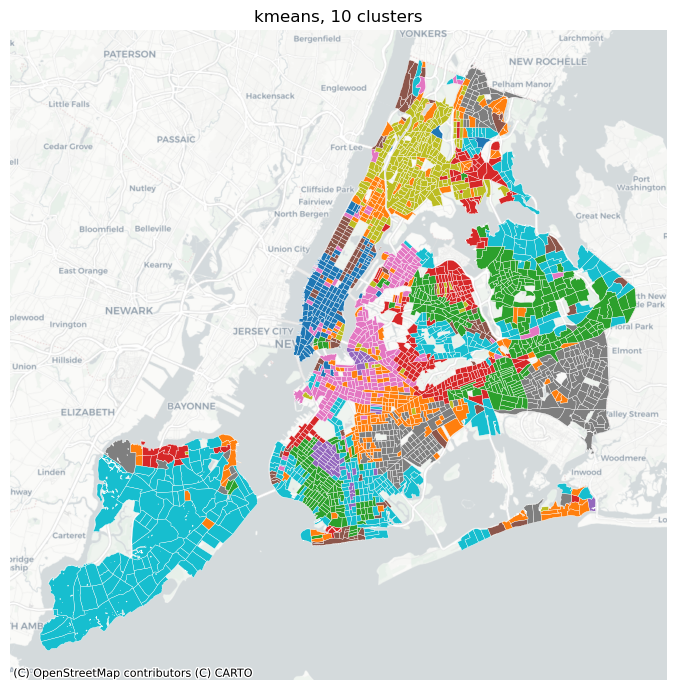

In [20]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Plot labels as categorical data
fig, ax = plotting.plot_categorical(nyc_demographics, model_name)
ax.set_title(f"{alg.code}, {NC} clusters")

Honestly, this is significantly better than I thought it would be. Already, we can see distinct regions emerge in different parts of the city! That said, it is clear that our clusters ignore spatial contiguity, in that demographically similar but geographically distant regions are clustered together:
- Staten Island is grouped with Middle Village and Forest Hills
- All three Chinatowns are grouped together (along with other immigrant communities like Jackson Heights)
- Many Hispanic-dominant areas like Corona (Queens), Sunset Park (Brooklyn), Woodhaven (Queens), and parts of the Bronx and Staten Island are all grouped together.
- Two heavily orthodox Jewish communities (Borough Park and South Williamsburg) are grouped together.

Additionally, some regions do not have well-defined geographical boundaries between clusters and instead feature tracts of multiple clusters interspersed, such as in South Brooklyn, Harlem, and Bed-Stuy. These represent demographic profiles on the boundary between two clusters over a geographically extended region.

Ultimately, I'd like a clustering algorithm that produces spatially contiguous and relatively compact clusters, while not ignoring demographic data. For that, we need spatial clustering algorithms.

## 2.2 Spatially constrained $k$-means (`sc-kmeans`)

A simple way to incorporate spatial information is to perform a normal clustering algorithm under the constraint of preserving spatial connectivity. The package `spopt` provides such a modification off of $k$-means with the model `spopt.region.RegionKMeansHeuristic()`, which I play with here.

A complication to spatial clustering with this model (and later ones as well) is that the solve breaks if not all tracts are fully connected. Even after removing the small isolated "island" tracts earlier, NYC still has 5 disconnected regions (The Bronx, Queens/Brooklyn, Manhattan, Rockaway Beach, and Staten Island). This means I actually need to run the model 5 times, one for each connected region. Most of these models require pre-specifying the number of clusters. To deal with this, I assign the clusters proportionally based on the number of tracts per connected region (see `utils.perform_multicomponent_cluster`).

In [21]:
# Define name of clustering model
alg = algorithms.sc_kmeans
NC = 40
NF = len(features.columns)
model_name = f"f{NF}_{alg.code}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NC,
                alg=alg,
                name=model_name,
                seed=42
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Here are the resulting clusters, labeled 0-39:

Text(0.5, 1.0, 'sc-kmeans, 40 clusters')

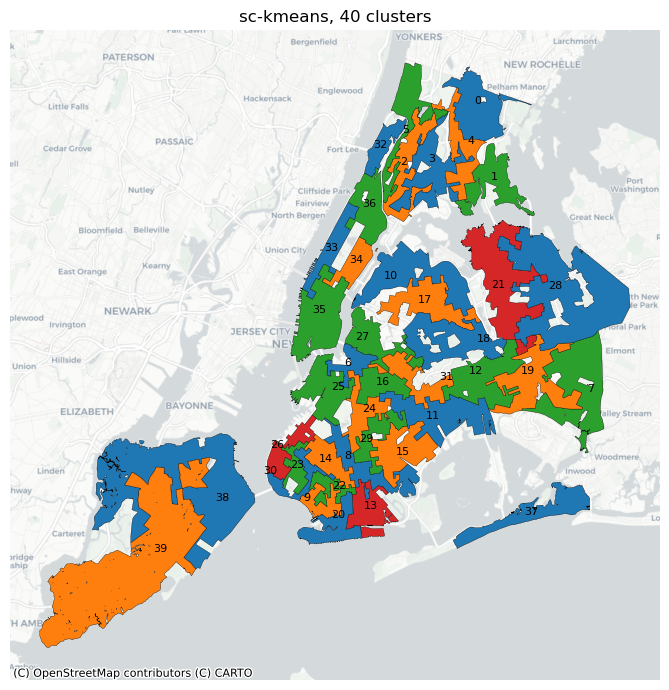

In [22]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{alg.code}, {NC} clusters")

This model at least produces contiguous regions, so we are closer to our goal. Still, a lot of these regions are snakey (e.g., cluster 2 in The Bronx and clusters 8 and 22 in south Brooklyn). Even with the spatial constraint, the algorithm still over-prioritizes compactness in feature space over that in geographical space. If it can find a path connecting two similar areas, no matter how snakey, it will do so.

## 2.3 Spatially constrained agglomerative clustering (`sc-agg`)

Unlike $k$-means, agglomerative clustering iteratively builds large clusters by merging smaller ones together. Combined with a spatial constraint of only merging contiguous clusters, this holds the potential to create more compact-looking clusters. Agglomerative clustering requires a "linkage" rule to determine which clusters to merge in any given step. I'll use a Ward linkage, which chooses merges that minimize the increase of within-cluster variances. Hopefully, this will create compact clusters both in feature space and geographically.

In [23]:
# Define name of clustering model
alg = algorithms.sc_agg
NC = 60
NF = len(features.columns)
model_name = f"f{NF}_{alg.code}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NC,
                alg=alg,
                name=model_name,
                seed=42 # not used for this model
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Text(0.5, 1.0, 'sc-agg, 60 clusters')

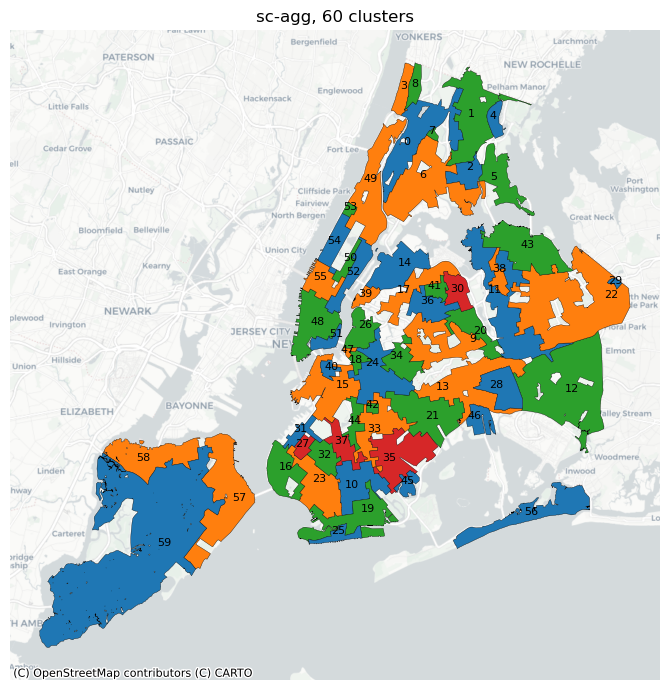

In [24]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{alg.code}, {NC} clusters")

Wow, these look a lot more realistic! Clusters are more compact and better align with prior expectations about NYC neighborhoods. There's a Flushing cluster (38), a Borough Park cluster (32), and a Harlem cluster (49), to name a few. This method seems to have some very small clusters (29, 42, 47) when using a larger cluster number like 60, for no apparent reason. It would be nice if I could implement a minimum cluster size, but that doesn't really work with the agglomerative nature of this clustering algorithm.

## 2.4 SKATER and REDCAP (`skater`, `redcap-*`)

Alternatively, there is a family of hierarchical clustering methods called REDCAP (with one named algorithm, SKATER, being a member of this family). These methods involve a two-part scheme:
- First, construct a spanning tree connecting all the tracts, in a way that linking together contiguous nodes into subtrees. Different members of the family construct different spanning trees:
    - Possible linkages include Ward (minimizing the variance between nodes in two subtrees), average (minimizing the average distance between nodes in two subtrees), single (choosing edges with minimal distance), and complete (minimizing the max distance between nodes in two subtrees). At each step, the pair of contiguous subtrees that minimizes the linkage criterion are merged
    - Contiguity can be enforced either at first order (the linkage only considers pairs of nodes that are directly contiguous) or full order (the linkage considers all pairs of nodes in two contiguous subtrees). This is subtle--the pair of subtrees must contain at least one pair of contiguous nodes regardless, but the contiguity order changes which pairs of nodes contribute to the linkage calculation.
- Second, successively prune the tree by cutting one edge per step. Each cut adds a new disconnected subtree, corresponding to a cluster. Cuts are made to minimize within-cluster dissimilarity.

The first step is similar in spirit to agglomerative clustering, with the closest analogy being a method enforcing first-order contiguity and using a Ward linkage. The main difference is that agglomerative clustering stops merging at the desired number of clusters, and REDCAP "merges" all the tracts into a single spanning tree (like one large cluster), followed by pruning back down to the desired number of clusters in the second step. In this way, REDCAP creates clusters informed by the full graph of tracts, rather than just using local similarities.

Additionally, these methods allow me to constrain the tree pruning to ensure each cluster has a minimum size! I enforce a minimum size of 5 tracts per cluster throughout. 

I implement REDCAP using the `pygeoda` library. An example of one of the methods is shown below.

In [6]:
# Define name of clustering model
alg = algorithms.redcap_full_average
NC = 60
NF = len(features.columns)
model_name = f"f{NF}_{alg.code}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NC,
                alg=alg,
                name=model_name,
                seed=42
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Text(0.5, 1.0, 'redcap-full-average, 60 clusters')

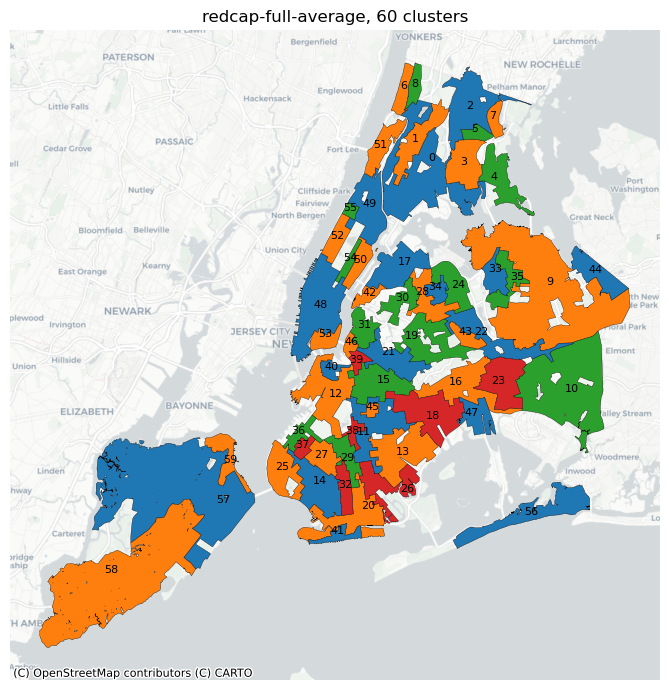

In [7]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{alg.code}, {NC} clusters")

Overall, this looks quite promising! Similar compactness to the agglomerative clustering algorithm from before, but with no 1-2 tract clusters.

# 3 Evaluation metrics

Some of the above clusterings seem pretty good! But how do we quantify this performance and determine the "best" clusters? Since this is an unsupervised classification problem, there is no ground truth about what label each tract "should" occupy. Instead, we can define a series of desirable properties for our clusters and then set up evaluation metrics that quantify these properties.

To study these metrics, I'll first load in the labels from the results of four different clustering algorithms, all with $n=60$ clusters.

In [27]:
# -- Load in labels from four different clustering algorithms (n=60 clusters) --
algs = [algorithms.kmeans, algorithms.sc_kmeans,
        algorithms.sc_agg,algorithms.redcap_full_average]
nyc_demographics = tracts.join(features_std)
feature_attrs = features_std.columns.to_numpy()
NC = 60
NF = len(features_std.columns)

# Read in models
model_names = []
for alg in algs:
    model_name = f"f{NF}_{alg.code}_n{NC}"
    model_names.append( model_name )

    # Load model and join with tracts and features
    clusters = pd.read_parquet(config.MODEL_DIR / f"{model_name}.parquet")
    nyc_demographics = nyc_demographics.join(clusters)

## 3.1 Polsby-Popper compactness score

We want our clusters to reflect a good balance of feature similarity and geographical compactness. The **Polsby-Popper score** measures the latter, with a larger score indicating more compactness. For a perfect circle (the most compact possible shape), the score is 1. As a region becomes more "snakey" and uses more perimeter length (keeping area fixed), the score decreases, for a minimum possible value of 0.

To demonstrate this, take a look at two clusters from `sc-kmeans` with 40 clusters below. On the right is a snakey cluster that receives a very low score. On the left is a reasonably compact cluster, reflected in the much higher score.

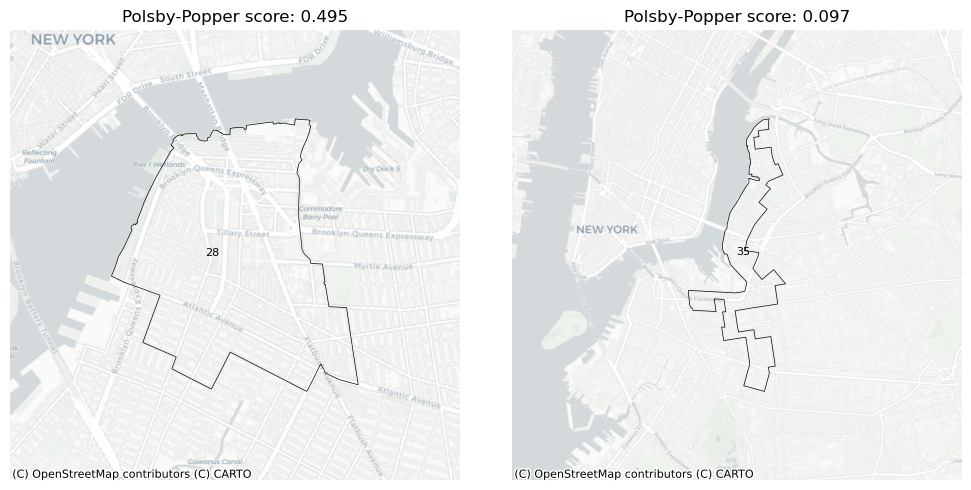

In [28]:
# -- Plot 2 clusters with their Polsby-Popper scores --

# Dissolve tracts into cluster regions and visualize
fig, ax = plt.subplots(1,2, figsize=(11,5))
__, __ = plotting.plot_clusters(
    nyc_demographics, "f11_sc-kmeans_n60",
    figax=(fig, ax[0]), color_clusters=False,
    which_clusters=[28]
)
__, __ = plotting.plot_clusters(
    nyc_demographics, "f11_sc-kmeans_n60",
    figax=(fig, ax[1]), color_clusters=False,
    which_clusters=[35]
)

# Calculate Polsby-Popper scores and plot
clusters = utils.aggregate_clusters(nyc_demographics, [], "f11_sc-kmeans_n60")
pp0 = evaluation.polsby_popper(clusters.loc[[28]])
pp1 = evaluation.polsby_popper(clusters.loc[[35]])
ax[0].set_title(f"Polsby-Popper score: {round(pp0, 3)}")
ax[1].set_title(f"Polsby-Popper score: {round(pp1, 3)}")
plt.show()

Below, I tabulate the Polsby-Popper scores (averaged across clusters) for four different clustering algorithms, each with 60 clusters. We see that `kmeans` has the least compact clusters. `sc-kmeans` is a little better but still substantially less compact than our other spatially aware methods like `redcap-*` and `sc-agg`.

In [29]:
# -- Evaluate Polsby-Popper for different algorithms --
eval_metrics = evaluation.tabulate_evaluation_metrics(
    nyc_demographics, feature_attrs, model_names,
    metric_names=["polsby-popper"]
)
eval_metrics.sort_values(by="polsby-popper", ascending=True)

polsby-popper
f11_kmeans_n60                    0.073224
f11_sc-kmeans_n60                 0.174204
f11_sc-agg_n60                    0.274056
f11_redcap-full-average_n60       0.275524

### Additional information: computing the Polsby-Popper score

For completeness, the formula for the Polsby-Popper score is as follows: if we have a region $R$ with area $A(R)$ and perimeter $P(R)$, the score $S_\mathrm{PP}(R)$ is
$$
S_\mathrm{PP}(R) = \frac{4\pi A(R)}{P(R)^2}.
$$
I hard-coded this metric in `src/evaluations.py`.

## 3.2 Davies-Bouldin score

The **Davies-Bouldin score** provides a measure of inter-cluster vs. intra-cluster feature similarity, described in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index). A large score implies that, on average, clusters are not well-separated from each other relative to their within-cluster spread. On the other hand, a small score indicates well-separated clusters.

### A "contiguous" Davies-Bouldin score

The Davies-Bouldin score is a spatially agnostic metric (it is defined purely in terms of feature space). As a result, when it finds pairs of clusters that are spatially distant but close together in feature space, it will penalize the clustering algorithm. As part of my exploration, I created a spatially aware Davies-Bouldin score (which I call `contiguous-dbs`) that only looks at contiguous cluster pairs when computing inter-cluster similarity.

To see the difference, consider the scores for different clustering algorithms below (each with 60 clusters):

In [30]:
# -- Evaluate Davies-Bouldin and contiguous DBS for different algorithms --
eval_metrics = evaluation.tabulate_evaluation_metrics(
    nyc_demographics, feature_attrs, model_names,
    metric_names=["davies-bouldin","contiguous-dbs"]
)
eval_metrics.sort_values(by="davies-bouldin", ascending=True)

davies-bouldin  contiguous-dbs
f11_kmeans_n60                     1.479639        1.477126
f11_sc-agg_n60                     2.206231        1.381168
f11_redcap-full-average_n60        2.246312        1.454208
f11_sc-kmeans_n60                  3.330152        2.737938

`kmeans` has by far the lowest Davies-Bouldin score, since it clusters purely on feature similarity. Spatially aware methods like `sc-agg` and `redcap-*` perform comparatively worse. However, when considering only *contiguous* pairs of clusters (the `contiguous-dbs` score), the spatially aware methods perform as well or better than `kmeans`, indicating that clusters are still locally well-separated. 

In either metric, `sc-kmeans` performs significantly worse than all other algorithms. Seems like it's the worst of both worlds: not compact in feature space or geographically!

### Additional information: calculating the Davies-Bouldin score

The Davies-Bouldin score is computed by first evaluating the within-cluster variation $s_{c}$ for each cluster $c$ (defined by the average distance of samples in that cluster to the cluster's centroid), as well as the inter-cluster centroid distances $d_{ck}$ for each pair of clusters $(c,k)$. Each cluster is then assigned a score $R_{c}$ based off its most similar other cluster, defined as
$$
R_{c} = \max_{k \neq c} \left( \frac{s_{c} + s_{k}}{d_{ck}} \right).
$$

The Davies-Bouldin score $S_\mathrm{DB}$ is then defined as the average of these scores over all clusters:
$$
S_\mathrm{DB} = \frac{1}{N_{c}} \sum_{c} R_{c}.
$$

My contiguity-constrained version computes $R_{c}$ by maximizing over only contiguous pairs of clusters. Therefore, `contiguous-dbs` is always less than or equal to the original Davies-Bouldin score.

## 3.3 Path silhouette

The silhouette score of a sample (tract) is a measure of how well the sample fits its assigned cluster, compared to the next best alternative. It ranges from -1 to 1, with a high score indicating the sample is much closer (in feature space) to other samples in its cluster than to those in any other cluster.

Because the silhouette score does not consider geographical proximity (its definition is purely in terms of feature space), spatially aware clustering methods tend to score worse than spatially agnostic methods like $k$-means. To remedy this, researchers Wolf, Knapp, and Rey introduced the **path silhouette** in 2019 ([[WKR2019]](https://doi.org/10.1177/2399808319875752), preprint link [here](https://doi.org/10.31235/osf.io/vd3uk)). This is like the normal silhouette, but when calculating the distance between two samples, it finds the shortest path connecting the two samples by traversing the adjacency graph. The "path distance" between the samples is then the sum of the distances between successive adjacent samples along the path. Non-adjacent samples can still have a short path distance if they can be connected by a path of other similar samples.

I tabulate the silhouette and path silhouette scores for the four clustering algorithms below.

In [31]:
# -- Evaluate path silhouette types for different algorithms --
eval_metrics = evaluation.tabulate_evaluation_metrics(
    nyc_demographics, feature_attrs, model_names,
    metric_names=["silhouette","path-silhouette"]
)
eval_metrics.sort_values(by="silhouette", ascending=True)

silhouette  path-silhouette
f11_sc-kmeans_n60             -0.061884         0.179228
f11_sc-agg_n60                 0.004617         0.194139
f11_redcap-full-average_n60    0.007479         0.210288
f11_kmeans_n60                 0.158898        -0.257113

Sure enough, the spatially agnostic `kmeans` has the highest silhouette score, but when we use the path silhouette it becomes the worst by far. All of the other algorithms perform similarly. Intuitively, we might expect that less compact ("snakier") clusters should be penalized in the path silhouette, since a tract in the snakey cluster are more likely to be path-closer to tracts in other clusters, rather than tracts in its own cluster. We do not see this in the path silhouette scores, however.

What's going on? Let's visualize the path silhouette for `sc-kmeans` and one of the more sophisticated algorithms (here, `redcap-full-average`):

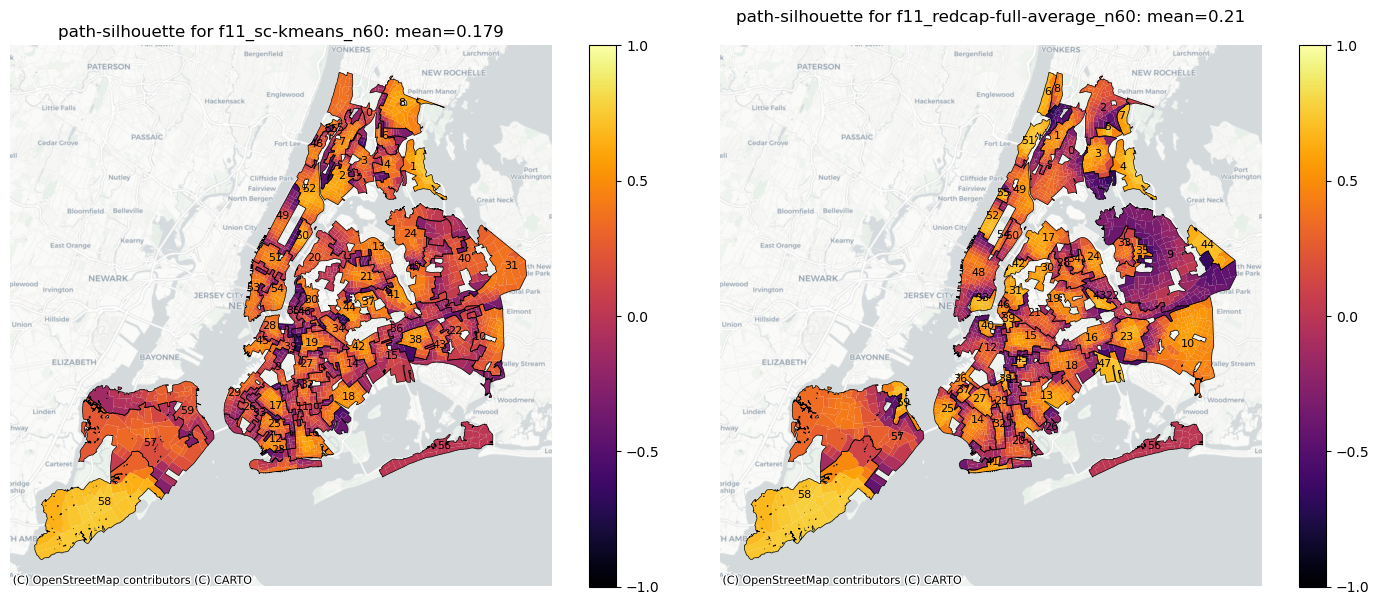

In [32]:
# -- Plot silhouette and path silhouette --
fig, ax = plt.subplots(1, 2, figsize=(15,6))
__, __ = plotting.plot_silhouette(
    nyc_demographics, feature_attrs,
    cluster_attr = "f11_sc-kmeans_n60",
    sil_type = "path-silhouette", figax=(fig, ax[0])
)
__, __ = plotting.plot_silhouette(
    nyc_demographics, feature_attrs,
    cluster_attr = "f11_redcap-full-average_n60",
    sil_type = "path-silhouette", figax=(fig, ax[1])
)

On the left, we do see that the snakey parts of tracts are in fact getting penalized with lower path silhouette scores, so that intuition is correct. But we also see many tracts in the right plot that are in relatively compact clusters but still have low scores (for example, clusters 2 and 9, as well as the edges of clusters 48, 12, and 57). I think this is because these clusters *are much larger than their neighbors*. Larger clusters have a longer average path-distance between two tracts, simply due to their geographical size, which lowers their path silhouette score. The effect is the most pronounced for tracts in a large cluster on the border with a particularly small cluster (like cluster 9 bordering 44).

### Truncated path silhouette

In light of this issue, I designed a custom metric which I call a "truncated" path silhouette. This is mostly the same as the normal path silhouette, but when comparing a tract's average distance to tracts in another cluster vs. its own cluster, I average over the same number of distances for both clusters. 

To give an example: suppose we have a tract in cluster 9 (with 121 other tracts) from the above plot that borders cluster 44 (with only 8 tracts). When computing the truncated path silhouette score for this tract, I average the intra-cluster distance *only over the 8 path-closest tracts* to our original tract. The hope is that this standardizes the path-distance penalty across the two clusters.

The truncated path silhouettes for `sc-kmeans` and `redcap-full-average` are shown below:

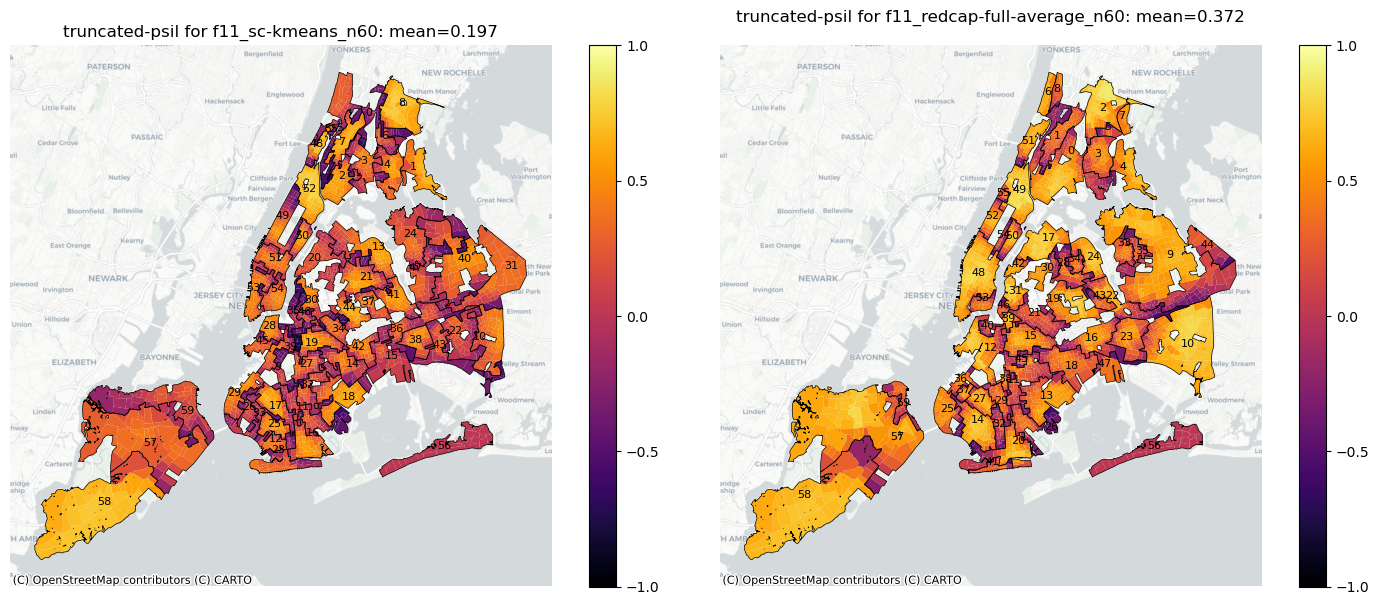

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
__, __ = plotting.plot_silhouette(
    nyc_demographics, feature_attrs,
    cluster_attr = "f11_sc-kmeans_n60",
    sil_type = "truncated-psil", figax=(fig, ax[0])
)
__, __ = plotting.plot_silhouette(
    nyc_demographics, feature_attrs,
    cluster_attr = "f11_redcap-full-average_n60",
    sil_type = "truncated-psil", figax=(fig, ax[1])
)

I think this metric was a success! I no longer see a penalty in the larger clusters--if anything, the interiors of the larger clusters have a remarkably high truncated path silhouette. But I think this is consistent with the intent of the path silhouette, which is to penalize clusters far away from the tract in question. Tracts deep inside a cluster are not close to any other clusters, so the path silhouette should be high.

Additionally, the truncated path silhouette of `sc-kmeans` very clearly penalizes the non-compact cluster shapes. For example, tracts in cluster 24 (northeast Queens) snake deep into cluster 40, and these tracts receive a low score due to the path-distance penalty. This shows up in the overall silhouette scores, tabulated below. Whereas `sc-kmeans` and the other spatial algorithms have similar path silhouettes, the former has a much lower *truncated* path silhouette score. `kmeans` continues to perform the worst on all path silhouette metrics.

In [34]:
# -- Evaluate path silhouette types for different algorithms --
eval_metrics = evaluation.tabulate_evaluation_metrics(
    nyc_demographics, feature_attrs, model_names,
    metric_names=["silhouette","path-silhouette","truncated-psil"]
)
eval_metrics.sort_values(by="truncated-psil", ascending=True)

silhouette  path-silhouette  truncated-psil
f11_kmeans_n60                 0.158898        -0.257113       -0.179053
f11_sc-kmeans_n60             -0.061884         0.179228        0.197123
f11_sc-agg_n60                 0.004617         0.194139        0.343271
f11_redcap-full-average_n60    0.007479         0.210288        0.372147

### Additional information: The path silhouette formula

The silhouette score $s(i)$ of a sample $i$ assigned to cluster $c$ is given by:
$$
s(i) = \frac{\overline{d}_{k^*}(i) - \overline{d}_{c}(i)}{\max \left(\overline{d}_{k^*}(i), \overline{d}_{c}(i) \right)},
$$
where $\overline{d}_{k}(i)$ is the average distance between sample $i$ and all the samples in cluster $k$, and $k^{*}$ is the "next-best" cluster assignment (not equal to $c$), which minimizes $\overline{d}_{k}(i)$. The denominator is a normalization factor. If sample $i$ is very close in feature space to all tracts in $c$ and far from all other clusters, then $\overline{d}_{c}(i) \ll \overline{d}_{k^*}(i)$, and the silhouette approaches 1. On the other extreme, if $c$ is a *really bad* assignment, then we might have $\overline{d}_{c}(i) \gg \overline{d}_{k^*}(i)$, making $s(i) \approx -1$.

My truncated path silhouette uses the same formula, but when considering a pair of clusters $(c,k)$, the distances $\overline{d}_{k}(i)$ and $\overline{d}_{c}(i)$ are averaged over the same number of tracts $N_{ck}$ in each cluster (the maximum size of the smaller of the two clusters, not including tract $i$ itself). When performing this truncation, the $N_{ck}$ path-closest distances are used.

# 4 Fine-tuning and discussion

Looking at the metrics from the previous section over a wide range of cluster numbers, the spatially constrained agglomerative clustering algorithm (`sc-agg`) consistently performs as well as or better than the REDCAP methods. However, this isn't a fair comparison because I further constrain the REDCAP methods to have a minimum cluster size of 5 tracts and cannot do so for the purely agglomerative method. Among the algorithms with a constrained cluster size, `redcap-full-average` seems to work best with our metrics, so I'll go with that. 

Let's see if we can fine-tune the number of clusters. Since the clustering works on each connected component separately, we can vary them independently and study how our evaluation metrics change.

In [9]:
# Setup piped in variables
gdf = tracts.join(features_std)
feature_attrs = features_std.columns
alg = algorithms.redcap_full_average
seed = 42
NC0 = 60

eval_metrics = evaluation.scan_component_n(gdf, feature_attrs, alg, NC0, scan_size_max=30, seed=seed)

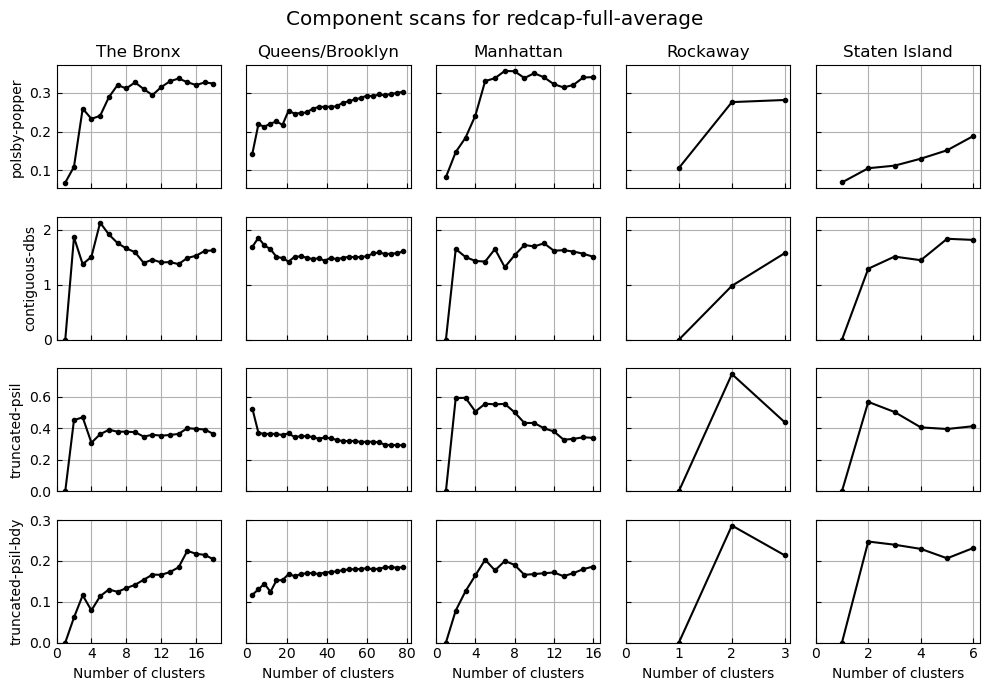

In [10]:
metrics = eval_metrics[["polsby-popper","contiguous-dbs","truncated-psil","truncated-psil-bdy"]]
component_names = ["The Bronx", "Queens/Brooklyn", "Manhattan", "Rockaway", "Staten Island"]
suptitle = f"Component scans for {alg.code}"
fig, ax = plotting.plot_component_scans(metrics, component_names, suptitle)
# ax[1,1].set_ylim((1.4,1.55))
# ax[1,1].set_xlim((20, 60))

Each connected component of our dataset gets its own column, and each row is a different evaluation metric. Let's look at each metric one at a time:
- Row 1: the Polsby-Popper index (higher is better)
    - Consistently, we find that more clusters improves the Polsby-Popper index, making them more compact. I'm not sure this is a great metric for varying cluster number for this reason--it's really better for comparing different algorithms with the same number of clusters.
- Row 2: the contiguity-constrained Davies-Bouldin score (lower is better)
    - The Bronx has some interesting structure, where the score is low for 3-4 clusters, as well as for 10-14 clusters. This seems to suggest different spatial scales where clusters are well-separated. I want to keep the number of tracts per cluster similar across connected components, so I will probably stick to the larger cluster region.
    - Other components are not so clear-cut. Queens/Brooklyn has a relatively flat region between 20-60 clusters. Manhattan is kind of flat but gets markedly worse at 9-12 clusters. Staten Island seems to get worse after 4, and Rockaway actually seems pretty good at 2 clusters.
- The "truncated" path silhouette score (higher is better), averaged over all tracts (row 3) and only tracts on cluster bounderies (row 4)
    - Why two metrics? For this metric, tracts deep in the interior of a cluster naturally score higher, and fewer such tracts exist at higher numbers. That means I'd expect the truncated path silhouette to gradually decrease as the cluster count goes up, which is more or less what we see in the data. Row 4 averages only over tracts on the boundary, which is a little more flat.
    - The Bronx and Queens/Brooklyn gradually improve in Row 4 over a wide range. Manhattan, again, gets worse starting with 9 clusters.

Based on this information, I will go with [11, 45, 8, 2, 4] clusters in order, for a total of 70 clusters (+4 for the small islands we removed earlier). This balances both our metrics and keeps the number of tracts per cluster relatively consistent across different components.



In [6]:
# Define name of clustering model
alg = algorithms.redcap_full_average
NCs = [11,45,8,2,4]
NC_code = "-".join([str(nc) for nc in NCs])
NF = len(features.columns)
model_name = f"f{NF}_{alg.code}_n{NC_code}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NCs,
                alg=alg,
                name=model_name,
                seed=42
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Our final clustering looks like this:

Text(0.5, 1.0, 'redcap-full-average, [11, 45, 8, 2, 4] clusters')

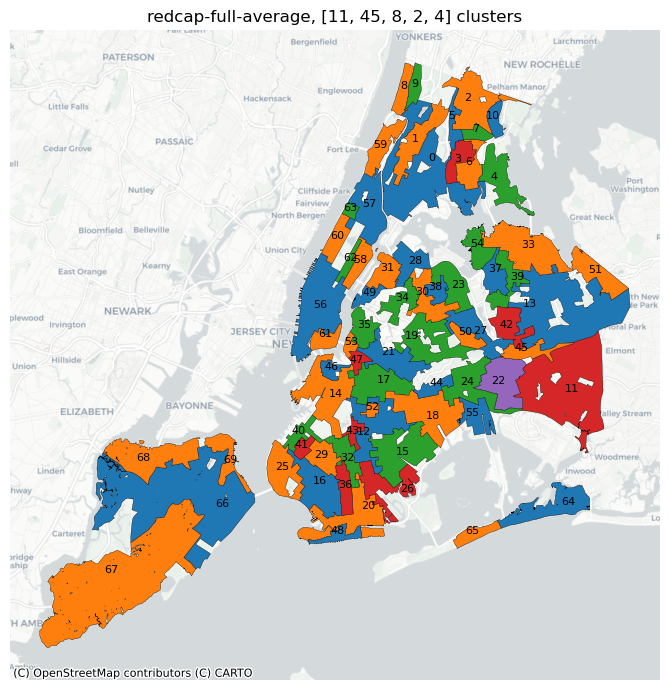

In [7]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{alg.code}, {NCs} clusters")

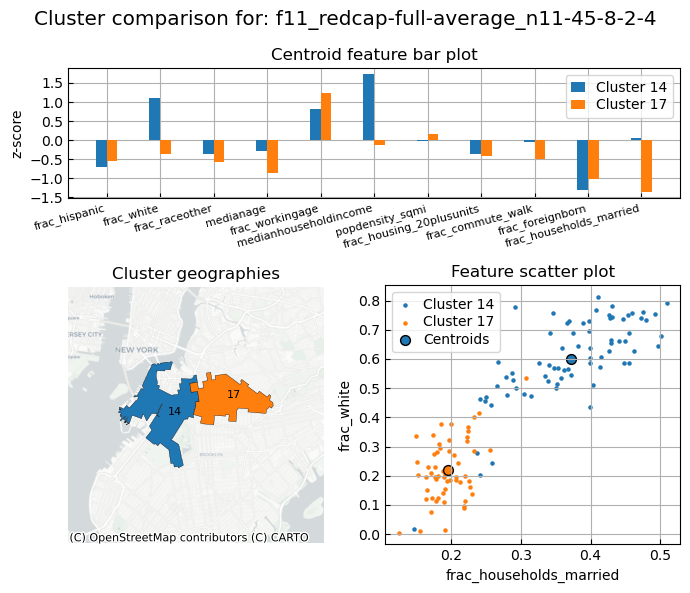

In [8]:
feature_attrs = features.columns
nyc_demographics[feature_attrs] = features
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, model_name,
    which_clusters=[14, 17]
)
